# Fall 2025 - Assignment 1

Electronic submission on ZoneCours no later than **October 17 at 11:55 PM** of:

* This Jupyter notebook (.ipynb) as the report, after adding your answers.
* All .py files necessary to run the notebook

The report must:

* be in .ipynb format (points will be deducted for any other format).
* include the student ID number of all team members in the first cell (i.e., replace these instructions).
* answer the questions and discuss the results using tables, figures, and Markdown cells.

Grading rubric:

* **40%** Accuracy of results
* **25%** Complete and concise discussions (Markdown cells)
* **20%** Conciseness of the notebook (.ipynb with minimal code) and clarity of figures
* **15%** Code clarity (.py)

# Context

We are going to consider the most liquid options traded on Apple on two particular business days of 2020: January 17 and March 20. The next couple of code cells were used to generate the dataset by connecting to OptionMetrics. With `GENERATE = False`, they simply load the dataset as saved to disk.

In [54]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script

import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib

##############################################################################
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [55]:
def filters(options):
    """These filters were applied to the data"""
    # Options before maturity
    options = options.loc[options.date < options.exdate].reset_index()

    # Positive open interest
    options = options[options['open_interest'] > 0]

    # Abs(delta) between 0.01 and 0.99
    options = options[(options['delta'].abs() >= 0.01) & (options['delta'].abs() <= 0.99)]

    # Implied vol between 0.03 and 2
    options = options[(options['impl_volatility'] >= 0.03) & (options['impl_volatility'] <= 2)]

    # Bid price is greater than 0.1 and less than ask price
    options = options[(options['best_offer'] > options['best_bid']) & (options['best_bid'] > 0.1)]

    return options

GENERATE = False
if GENERATE:
    import dorion_francois.option_metrics as om
    jan17 = om.get_option_data(101594, dt.date(2020,1,17))
    mar20 = om.get_option_data(101594, dt.date(2020,3,20))
    options = filters( pd.concat((jan17,mar20),axis=0) )
    with open('202510-assignment1.pkl','wb') as fh:
        # OptionMetrics 'strike_price' column is the strike x1000. We'll drop it to avoid confusion; use the 'strike' column
        pickle.dump(options.drop(columns=['strike_price']),fh)
else:
    with open('202510-assignment1.pkl','rb') as fh:
        options = pickle.load(fh)
options.describe()

,index,secid,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,...,option_price,DTM,YTM,risk_free,stock_price,stock_exdiv,implied_forward_price,implied_vol_bms,implied_vol_bid,implied_vol_ask
count,3041.000000,3041.0,3041.0,3041.0,3041.0,3041.0,3041.000000,3041.0,3041.0,3041.0,...,3041.0,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3039.000000,2907.000000,3041.000000
mean,1290.575469,101594.0,39.54265,41.070812,302.719171,1493.480434,0.486984,0.051175,0.004216,43.996647,...,40.306731,247.602105,0.678362,0.011057,267.849300,266.408353,268.266957,0.491364,0.463369,0.517211
std,588.418749,0.0,47.505847,48.379765,1413.149222,2810.188475,0.246677,0.573104,0.00421,39.878651,...,47.939597,256.838994,0.703668,0.005106,44.329611,44.126488,45.364910,0.240483,0.227888,0.264064
min,166.000000,101594.0,0.11,0.14,0.0,1.0,0.209335,-0.989916,0.00004,0.264909,...,0.13,7.000000,0.019178,0.004597,229.240000,226.093746,227.456884,0.209760,0.004413,0.211192
25%,805.000000,101594.0,3.85,4.75,0.0,76.0,0.308580,-0.332122,0.001665,13.6014,...,4.25,35.000000,0.095890,0.006167,229.240000,227.603325,228.595023,0.313801,0.290405,0.324194
50%,1334.000000,101594.0,20.05,21.5,14.0,383.0,0.407585,0.02422,0.003027,29.80537,...,20.8,154.000000,0.421918,0.008564,229.240000,229.240000,229.774853,0.414581,0.389198,0.437239
75%,1800.000000,101594.0,60.75,63.0,97.0,1594.0,0.593389,0.526664,0.005168,64.20898,...,61.75,455.000000,1.246575,0.016588,318.730000,317.145554,319.221626,0.603811,0.573138,0.637671
max,2345.000000,101594.0,271.0,275.5,29443.0,28015.0,1.998797,0.989859,0.042843,193.543,...,273.25,882.000000,2.416438,0.017424,318.730000,318.730000,325.069560,1.656574,1.601841,2.527934


# Question 1

Create a scatter plot with the risk-free rate (`100*options.risk_free`) against the time to maturity expressed in years (`options.YTM`). Discuss the figure. Given that the Black-Merton-Scholes economy assumes that the risk-free rate is constant, should one still account for the variation it illustrates if pricing options with the model? Why?

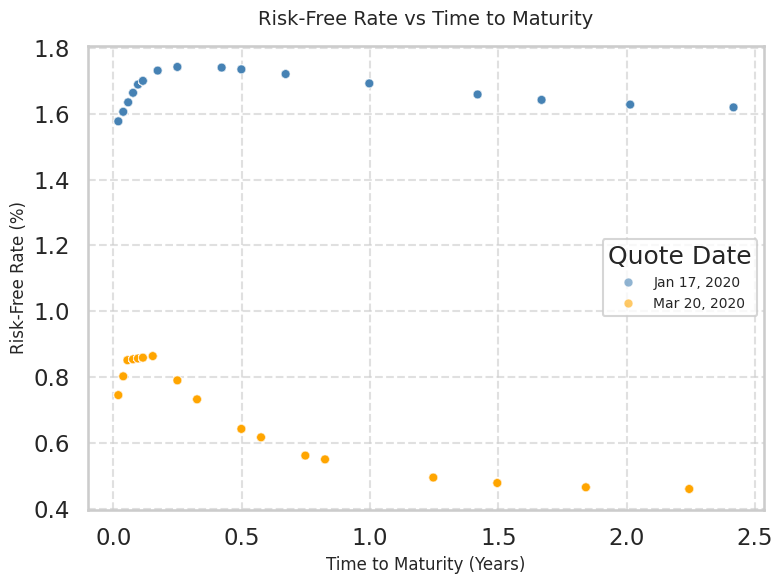

In [57]:
df = options[['YTM', 'risk_free', 'date']].dropna().copy()

# Label quote dates
df['quote_date'] = pd.to_datetime(df['date']).dt.normalize().map({
    pd.Timestamp('2020-01-17'): 'Jan 17, 2020',
    pd.Timestamp('2020-03-20'): 'Mar 20, 2020'
})

df = df[df['quote_date'].notna()]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='YTM',
    y=100 * df['risk_free'],
    hue='quote_date',
    palette={'Jan 17, 2020': 'steelblue', 'Mar 20, 2020': 'orange'},
    alpha=0.6,
    s=40
)

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Risk-Free Rate (%)")
plt.title("Risk-Free Rate vs Time to Maturity", pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Quote Date")
plt.tight_layout()
plt.show()

As we can observe, rates dropped sharply from January to March 2020.
For the Jan 17th quote date, the curve sits higher than the March 2020 curve (orange).
The lower post-COVID curve (March 2020) reflects the Federal Reserve’s emergency rate cuts and the flight to safety that followed the market turmoil. Investors rushed into short-term Treasury bills and government bonds, pushing yields sharply lower across all maturities. The short end dropped the most as the Fed slashed policy rates close to zero, while long-term rates also fell due to expectations of a prolonged period of low growth and low inflation.
The downward-sloping curve is consistent with economic intuition. Investors required higher short-term rates in early 2020 because monetary policy had not yet adjusted to the coming slowdown, while long-term rates were lower as markets anticipated future rate cuts and weaker growth.
Even in January 2020, before the COVID-19 shock, the yield curve was already relatively flat or slightly downward-sloping. This was consistent with the economic context: markets were expecting further monetary easing and slower long-term growth following several Fed rate cuts in 2019.
Therefore, even pre-COVID, investors demanded lower long-term rates, anticipating a softening economy and lower inflation. In other words, investors accepted lower yields for long maturities because they expected the economy and interest rates to decline in the future. This shape thus reflects rational expectations and is typical before recessions or during periods of anticipated monetary easing.
We can also see more unevenness on the short end of the curve in March (COVID stress period). The variation observed in the rate across maturities is consistent with the BMS model, which assumes a constant rate per option, not across all maturities. Using maturity-appropriate rates is therefore necessary to avoid mispricing options.

# Question 2
Similarly, scatter `options.stock - options.stock_exdiv`, where the former is the stock price and the latter accounts for the dividends **actually** paid over the life of the options.

Discuss the figure. Can we conclude that Apple changed its dividend policy between the two dates? Describe which variation of the Black-Merton-Scholes formula seen in class could be used to price the options on Apple if they were European options. Support your discussion with succinct mathematical expressions and/or derivations, in which you can focus on the calls without loss of generality.

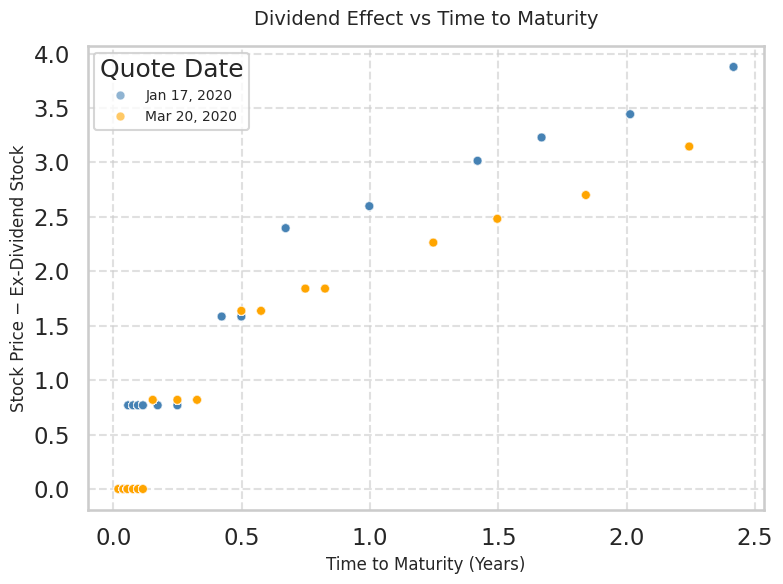

In [58]:
df = options[['YTM', 'stock_price', 'stock_exdiv', 'date']].dropna().copy()
df['div_eff'] = df['stock_price'] - df['stock_exdiv']

# Label quote dates
df['quote_date'] = pd.to_datetime(df['date']).dt.normalize().map({
    pd.Timestamp('2020-01-17'): 'Jan 17, 2020',
    pd.Timestamp('2020-03-20'): 'Mar 20, 2020'
})

df = df[df['quote_date'].notna()]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='YTM',
    y='div_eff',
    hue='quote_date',
    palette={'Jan 17, 2020': 'steelblue', 'Mar 20, 2020': 'orange'},
    alpha=0.6,
    s=40
)

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Stock Price − Ex-Dividend Stock")
plt.title("Dividend Effect vs Time to Maturity", pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Quote Date")
plt.tight_layout()
plt.show()


As the plot shows, the present value of dividends paid before option expiry increases with maturity. This is consistent with expectations: the longer the horizon, the more dividend payments occur during the option’s life. The January curve lies consistently above the March curve for the same maturities, particularly beyond 1.5 years.
The gap between both curves does not indicate any change in Apple’s dividend policy. Between January and March, one quarterly dividend payment occurred, explaining the lower March curve. For the same remaining maturities, there are simply fewer dividends left to be paid during the option’s life, which mechanically reduces the difference between S and S_ex-div.

AJOUTER DEUXIEME PARTIE POUR FORMULES.

# Question 3
Implement a function that inverts this variation of the BSM formula to obtain the BMS implied volatility for each of the options in the dataframe. Define moneyness as $M = K / \hat{S}_t$ and focus on out-of-the-money (OTM) options ($M \le 1$ puts, $M > 1$ calls). Create a dataframe `otm_options` containing only those options and add a column with the result of your IV calculation for each option therein.

In a 1x2 figure, scatter your results, with  on the x-axis, against a line plot for `implied_vol_bms`: In the left (right) panel, use options quoted on Jan 17 and expiring on Feb 14 (July 17), 2020, and options quoted on Mar 20 expiring on April 17 (Oct. 16), 2020. On each panel, you should thus have 2 lines with your results scattered atop them. Discuss this figure: how does the level and span (across moneyness) of the smiles vary, compare across maturities, etc. Given your discussion, can you suggest a better measure for moneyness? If you generate anew the previous figure using this alternate moneyness measure, how does it impact your analysis of the figure?

In [ ]:
from scipy.stats import norm
from scipy.optimize import brentq

# Black–Scholes price
def bs_price(S, K, r, tau, sigma, cp):
    if sigma <= 0 or tau <= 0:
        intrinsic = max(0.0, (S - K) if cp == "C" else (K - S)) #forced to be added otherwise with get div 0
        return intrinsic
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    if cp == "C":
        return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    else:  # "P"
        return K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied vol
def implied_vol(price, S, K, r, tau, cp, vol_lo=1e-6, vol_hi=5.0):
    forward = S * np.exp(r * tau)
    intrinsic = max(0.0, (S - K) if cp == "C" else (K - S))
    upper_bound = S if cp == "C" else K * np.exp(-r * tau)
    if not (intrinsic <= price <= upper_bound + 1e-8):
        return np.nan

    # Root
    def f(sig):
        return bs_price(S, K, r, tau, sig, cp) - price

    try:
        lo, hi = vol_lo, vol_hi
        flo, fhi = f(lo), f(hi)
        if flo * fhi > 0:
            for hi in (7.5, 10.0):
                if f(lo) * f(hi) <= 0:
                    break
            else:
                return np.nan
        return brentq(f, lo, hi, maxiter=200, xtol=1e-8)
    except Exception:
        return np.nan

# Compute IVs

options = options.copy()

# Moneyness
options["M"] = options["strike"] / options["stock_exdiv"]

# OTM mask
mask_otm = ((options["cp_flag"] == "P") & (options["M"] <= 1.0)) | \
           ((options["cp_flag"] == "C") & (options["M"] > 1.0))

otm_options = options.loc[mask_otm].copy()

# Compute IV per-row
def _row_iv(row):
    return implied_vol(
        price=row["option_price"],
        S=row["stock_exdiv"],
        K=row["strike"],
        r=row["risk_free"],
        tau=row["YTM"],
        cp=row["cp_flag"]
    )

otm_options["iv_bsm"] = otm_options.apply(_row_iv, axis=1)


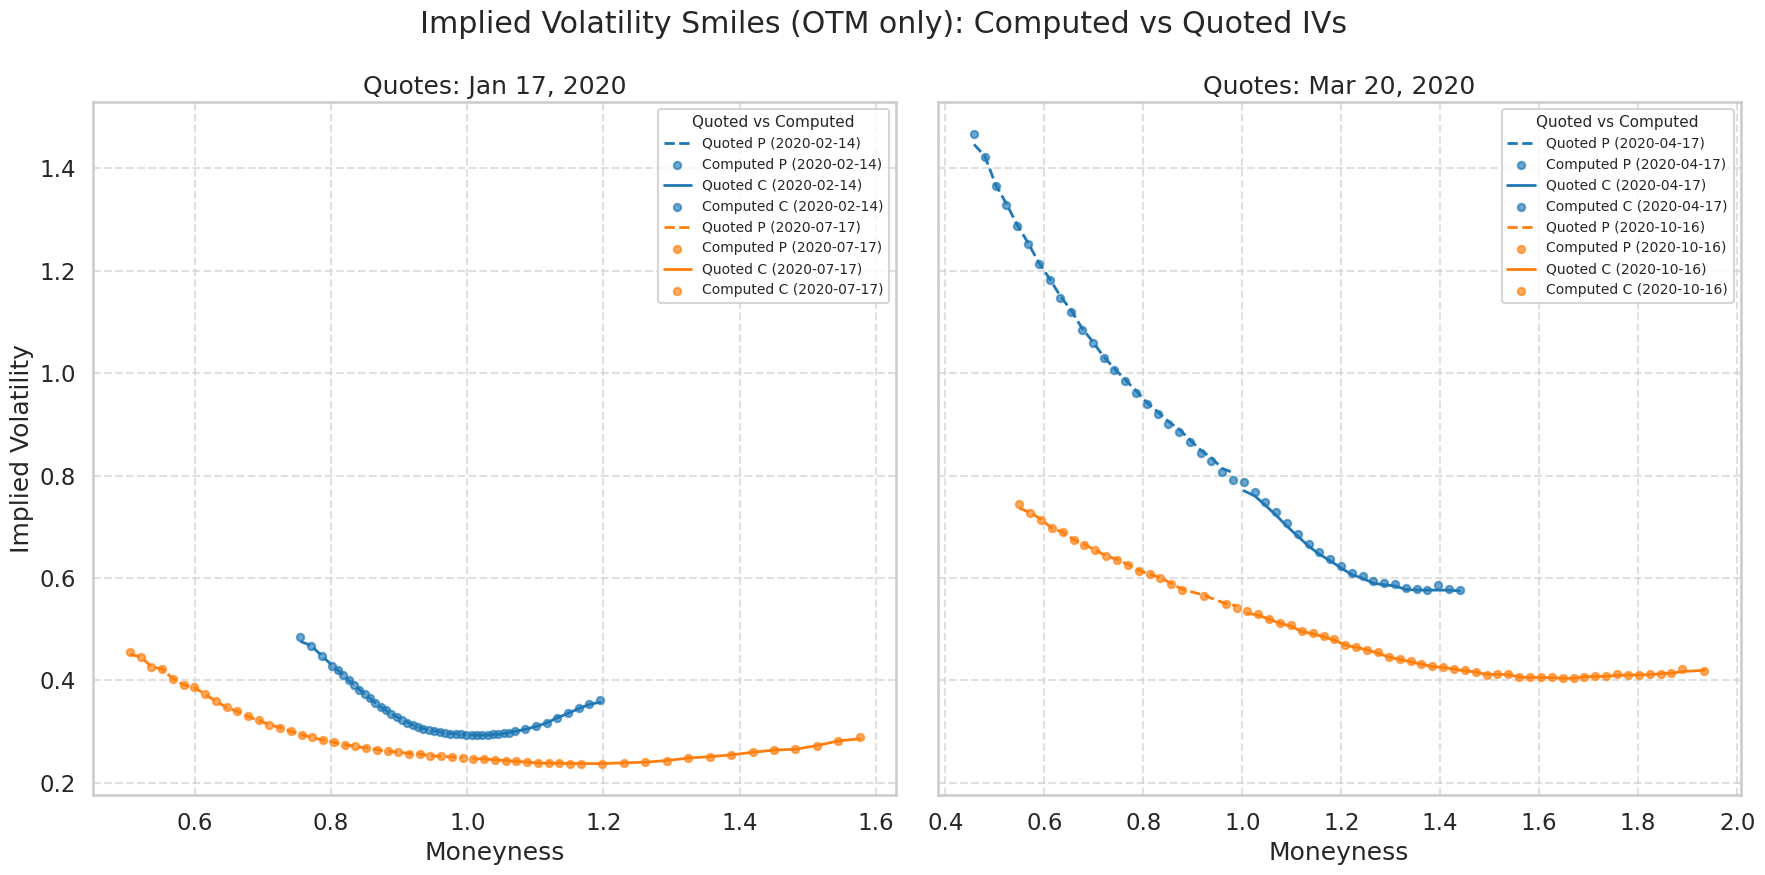

In [ ]:
### To replace ###
QUOTE_LEFT  = pd.Timestamp("2020-01-17")
EXPS_LEFT   = [pd.Timestamp("2020-02-14"), pd.Timestamp("2020-07-17")]
QUOTE_RIGHT = pd.Timestamp("2020-03-20")
EXPS_RIGHT  = [pd.Timestamp("2020-04-17"), pd.Timestamp("2020-10-16")]

# reference IV
iv_ref_col = next(c for c in ["implied_vol_bms","impl_volatility","impl_vol"] if c in options.columns)

opt = options.copy()
opt["date"]   = pd.to_datetime(opt["date"]).dt.tz_localize(None).dt.normalize()
opt["exdate"] = pd.to_datetime(opt["exdate"]).dt.tz_localize(None).dt.normalize()
opt["M"] = opt["strike"] / opt["stock_exdiv"]

# OTM mask
mask_otm = ((opt["cp_flag"]=="P") & (opt["M"]<=1.0)) | ((opt["cp_flag"]=="C") & (opt["M"]>1.0))

# reference
ref = opt.loc[mask_otm, ["date","exdate","cp_flag","M",iv_ref_col]].dropna().copy()

otm_options = otm_options.copy()
otm_options["date"]   = pd.to_datetime(otm_options["date"]).dt.tz_localize(None).dt.normalize()
otm_options["exdate"] = pd.to_datetime(otm_options["exdate"]).dt.tz_localize(None).dt.normalize()

# computed IVs
mine = otm_options.loc[:, ["date","exdate","cp_flag","M","iv_bsm"]].dropna().copy()

# rolling median smoothing
def smooth_by_M(df, ycol, win=3):
    d = df.sort_values("M").copy()
    if len(d) >= win:
        d[ycol] = d[ycol].rolling(win, center=True, min_periods=1).median()
    return d

#set up for figure
def plot_panel(ax, qdate, expiries, title):
    colors = sns.color_palette(n_colors=len(expiries))
    ls_map = {"P":"--", "C":"-"}

    for i, exp in enumerate(expiries):
        for cp in ["P","C"]:
            r = ref[(ref["date"]==qdate) & (ref["exdate"]==exp) & (ref["cp_flag"]==cp)]
            m = mine[(mine["date"]==qdate) & (mine["exdate"]==exp) & (mine["cp_flag"]==cp)]

            if not r.empty:
                r = smooth_by_M(r, iv_ref_col, win=3)
                ax.plot(
                    r["M"], r[iv_ref_col],
                    ls_map[cp], color=colors[i], lw=2,
                    label=f"Quoted {cp} ({exp.date()})"
                )

            if not m.empty:
                m = m.sort_values("M")
                ax.scatter(
                    m["M"], m["iv_bsm"],
                    color=colors[i], s=28, alpha=0.65,
                    label=f"Computed {cp} ({exp.date()})"
                )

    ax.set_title(title)
    ax.set_xlabel(r"Moneyness")
    ax.grid(True, linestyle="--", alpha=0.6)

sns.set_context("talk"); sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(18, 9), sharey=True)

plot_panel(axes[0], QUOTE_LEFT,  EXPS_LEFT,  "Quotes: Jan 17, 2020")
plot_panel(axes[1], QUOTE_RIGHT, EXPS_RIGHT, "Quotes: Mar 20, 2020")

axes[0].set_ylabel("Implied Volatility")

for ax in axes:
    ax.legend(
        title="Quoted vs Computed",
        frameon=True,
        fontsize=10,
        title_fontsize=11,
        loc="upper right",
        ncol=1
    )

fig.suptitle("Implied Volatility Smiles (OTM only): Computed vs Quoted IVs")
fig.tight_layout()
plt.show()


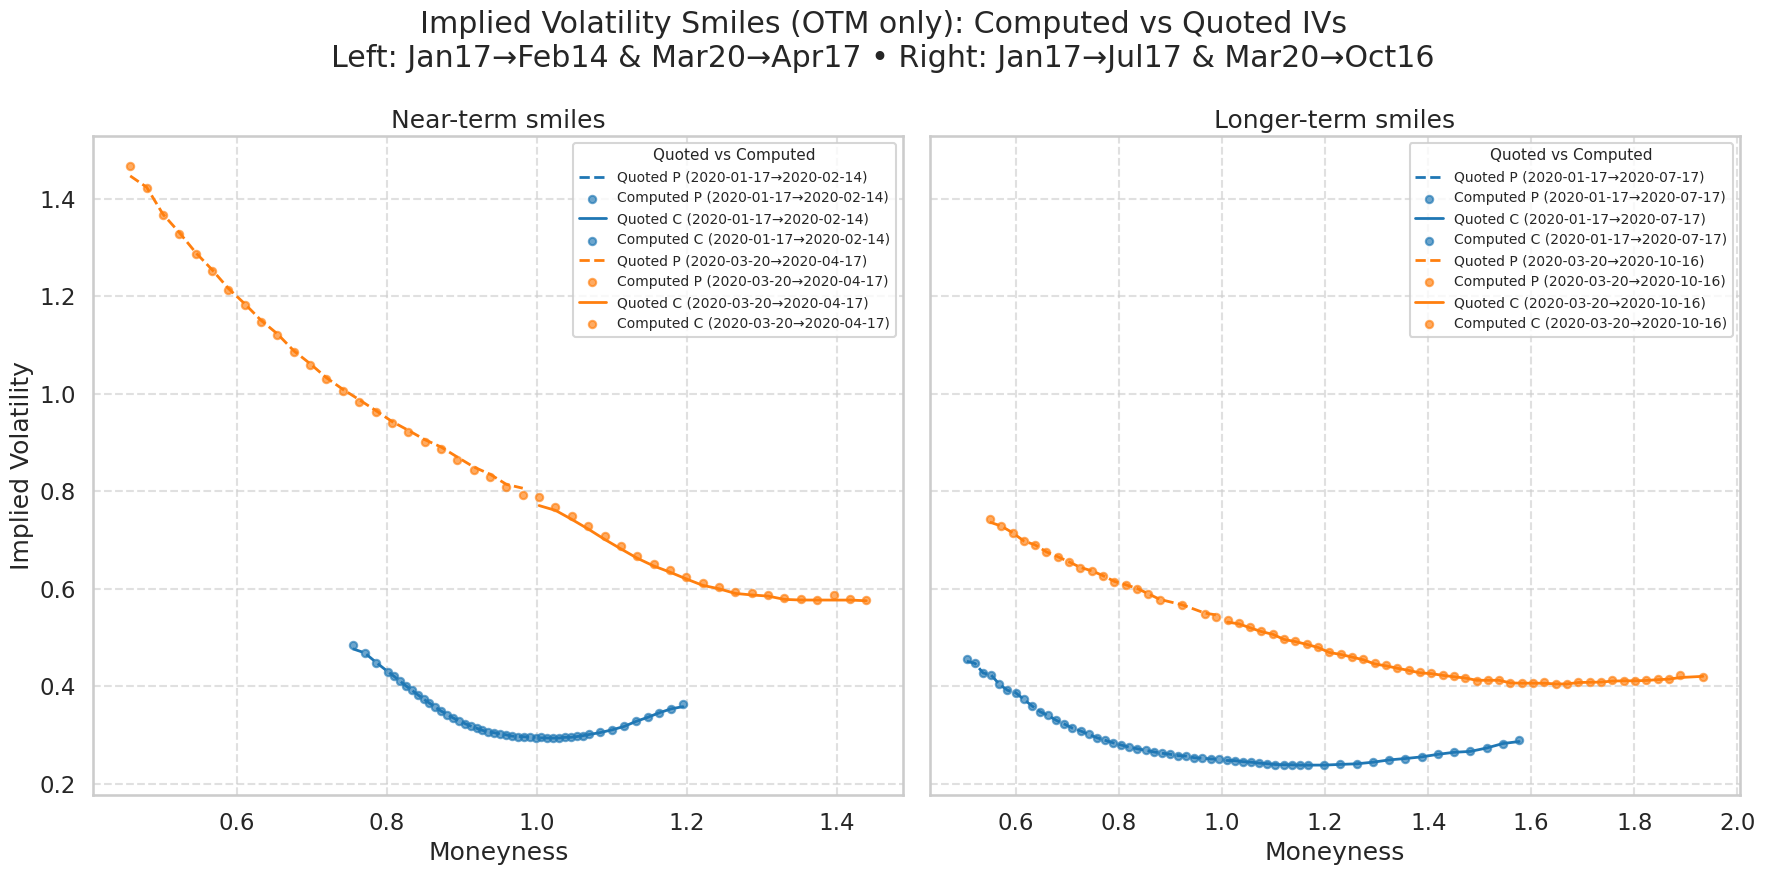

In [ ]:
### VERSION AVEC PANNELS CORRECTED BASED ON YOUR VERSION ###
### Keep first chunk of code : B&S price .... to otm_options ###


iv_ref_col = next(c for c in ["implied_vol_bms","impl_volatility","impl_vol"] if c in options.columns)

opt = options.copy()
opt["date"]   = pd.to_datetime(opt["date"]).dt.tz_localize(None).dt.normalize()
opt["exdate"] = pd.to_datetime(opt["exdate"]).dt.tz_localize(None).dt.normalize()
opt["M"] = opt["strike"] / opt["stock_exdiv"]

# OTM mask (unchanged)
mask_otm = ((opt["cp_flag"]=="P") & (opt["M"]<=1.0)) | ((opt["cp_flag"]=="C") & (opt["M"]>1.0))

# Quoted (provider) IV table
ref = opt.loc[mask_otm, ["date","exdate","cp_flag","M", iv_ref_col]].dropna().copy()

# Computed IV table (from your earlier block)
otm_options = otm_options.copy()
otm_options["date"]   = pd.to_datetime(otm_options["date"]).dt.tz_localize(None).dt.normalize()
otm_options["exdate"] = pd.to_datetime(otm_options["exdate"]).dt.tz_localize(None).dt.normalize()
mine = otm_options.loc[:, ["date","exdate","cp_flag","M","iv_bsm"]].dropna().copy()

# Smoothing helper (unchanged)
def smooth_by_M(df, ycol, win=3):
    d = df.sort_values("M").copy()
    if len(d) >= win:
        d[ycol] = d[ycol].rolling(win, center=True, min_periods=1).median()
    return d

# Left  panel: Jan 17 → Feb 14   AND   Mar 20 → Apr 17   (2020)
# Right panel: Jan 17 → Jul 17   AND   Mar 20 → Oct 16   (2020)
PAIRS_LEFT  = [(pd.Timestamp("2020-01-17"), pd.Timestamp("2020-02-14")),
               (pd.Timestamp("2020-03-20"), pd.Timestamp("2020-04-17"))]
PAIRS_RIGHT = [(pd.Timestamp("2020-01-17"), pd.Timestamp("2020-07-17")),
               (pd.Timestamp("2020-03-20"), pd.Timestamp("2020-10-16"))]

# Plotting (same look & feel, just loop over pairs instead of one qdate+2 exps)
sns.set_context("talk"); sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 9), sharey=True)

def plot_panel_pairs(ax, pairs, title):
    colors = sns.color_palette(n_colors=len(pairs))
    ls_map = {"P":"--", "C":"-"}  # keep P/C styles

    for i, (qdate, exp) in enumerate(pairs):
        color = colors[i]
        for cp in ["P","C"]:
            r = ref[(ref["date"]==qdate) & (ref["exdate"]==exp) & (ref["cp_flag"]==cp)]
            m = mine[(mine["date"]==qdate) & (mine["exdate"]==exp) & (mine["cp_flag"]==cp)]

            if not r.empty:
                r = smooth_by_M(r, iv_ref_col, win=3)
                ax.plot(
                    r["M"], r[iv_ref_col],
                    ls_map[cp], color=color, lw=2,
                    label=f"Quoted {cp} ({qdate.date()}→{exp.date()})"
                )

            if not m.empty:
                m = m.sort_values("M")
                ax.scatter(
                    m["M"], m["iv_bsm"],
                    color=color, s=28, alpha=0.65,
                    label=f"Computed {cp} ({qdate.date()}→{exp.date()})"
                )

    ax.set_title(title)
    ax.set_xlabel("Moneyness")
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(
        title="Quoted vs Computed",
        frameon=True, fontsize=10, title_fontsize=11,
        loc="upper right", ncol=1
    )

plot_panel_pairs(axes[0], PAIRS_LEFT,  "Near-term smiles")
plot_panel_pairs(axes[1], PAIRS_RIGHT, "Longer-term smiles")

axes[0].set_ylabel("Implied Volatility")
fig.suptitle("Implied Volatility Smiles (OTM only): Computed vs Quoted IVs\n"
             "Left: Jan17→Feb14 & Mar20→Apr17 • Right: Jan17→Jul17 & Mar20→Oct16")
fig.tight_layout()
plt.show()


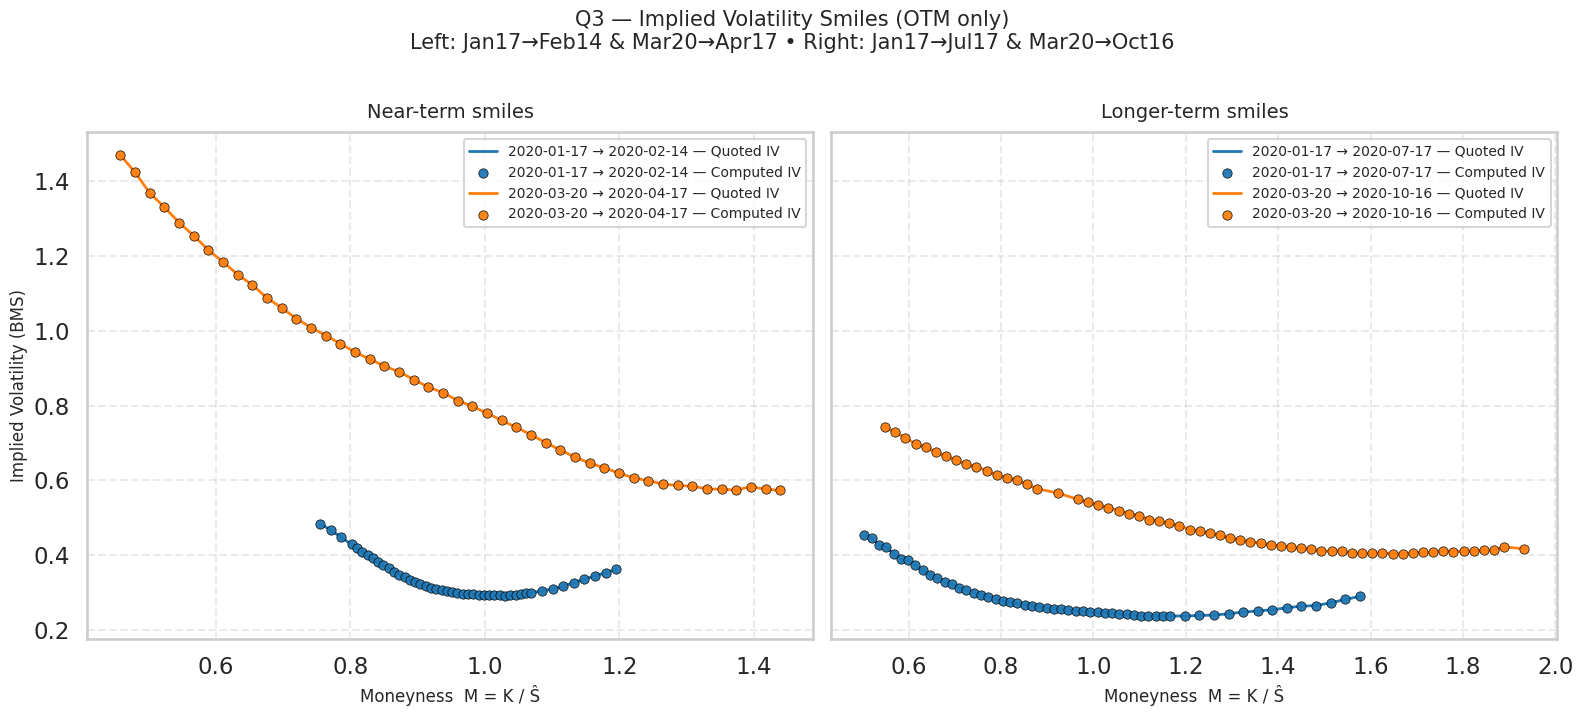

In [ ]:
#### VERSION LOUBNA WITH RIGHTPANNELS ##
#### FULL CODE FROM PRICING TO PLOTTING ###

# --- Define column names for consistency ---
# General columns
DATE = 'date'
EXDATE = 'exdate'
K = 'strike'
S = 'stock_price'
S_EX = 'stock_exdiv'     # S-hat used for moneyness
T = 'YTM'             # years to maturity
RF = 'risk_free'       # (assumed cont. comp. annualized)
DTM = 'DTM'           # days to maturity
OPTION_PRICE = 'option_price'
F_IMP  = 'implied_forward_price'

# Implied Volatility columns
IV_QUOTED = 'impl_volatility'      # Data provider's implied volatility (proprietary)
IV_BMS_QUOTED = 'implied_vol_bms' # Data provider’s BMS IV for comparison

# Option specific columns
CP = 'is_call'         # 1 = call, 0 = put

# ---------- Pricing & IV ----------
def BMS_price(S0, K_val, T_val, r, y, sigma, is_call):
    """Black–Merton–Scholes price with continuous dividend yield y."""
    if T_val <= 0:
        discS = S0*np.exp(-y*T_val)
        discK = K_val*np.exp(-r*T_val)
        return max(0.0, discS - discK) if is_call else max(0.0, discK - discS)

    sigma = max(1e-10, float(sigma))
    d1 = (np.log(S0/K_val) + (r - y + 0.5*sigma**2)*T_val) / (sigma*np.sqrt(T_val))
    d2 = d1 - sigma*np.sqrt(T_val)
    if is_call:
        return np.exp(-y*T_val)*S0*norm.cdf(d1) - K_val*np.exp(-r*T_val)*norm.cdf(d2)
    else:
        return K_val*np.exp(-r*T_val)*norm.cdf(-d2) - np.exp(-y*T_val)*S0*norm.cdf(-d1)

def vega_BMS(S0, K_val, T_val, r, y, sigma):
    """BMS vega under continuous dividend yield y."""
    if T_val <= 0:
        return 0.0
    sigma = max(1e-10, float(sigma))
    d1 = (np.log(S0/K_val) + (r - y + 0.5*sigma**2)*T_val) / (sigma*np.sqrt(T_val))
    return np.exp(-y*T_val)*S0*np.sqrt(T_val)*norm.pdf(d1)

def IV_newton(mkt_p, S0, K_val, T_val, r, y, is_call, x0=0.2, tol=1e-8, maxit=100):
    """Invert BMS using Newton–Raphson with an fsolve ."""
    sigma = max(1e-4, float(x0))
    for _ in range(maxit):
        px = BMS_price(S0, K_val, T_val, r, y, sigma, is_call)
        diff = px - mkt_p
        if abs(diff) < tol:
            return float(max(1e-8, sigma))
        v = vega_BMS(S0, K_val, T_val, r, y, sigma)
        if v <= 1e-12:
            break
        sigma = max(1e-8, sigma - diff / v)

    root = fsolve(lambda s: BMS_price(S0, K_val, T_val, r, y, s, is_call) - mkt_p, sigma, xtol=tol)
    return float(max(1e-8, root[0]))


# ---------- Data preparation ----------
def infer_y_row(row):
    """y = r - ln(F/S)/T   (cash-and-carry using implied_forward_price)."""
    T_val = float(row[T])
    F_val = float(row[F_IMP]) if pd.notna(row[F_IMP]) else np.nan
    if (T_val <= 0) or (not np.isfinite(F_val)) or (F_val <= 0):
        return 0.0
    return float(row[RF] - np.log(F_val/row[S]) / T_val)

def build_otm_options(options: pd.DataFrame) -> pd.DataFrame:
    """
    From the full options DF, build the OTM subset and compute BMS+y IV
    (column 'cmptd_IV'). Returns the otm_options DF
    """
    req = [DATE, EXDATE, CP, K, S, S_EX, T, RF, F_IMP, OPTION_PRICE, IV_BMS_QUOTED, IV_QUOTED] # Added IV_QUOTED here
    df = options[req].dropna().copy()
    df[DATE]   = pd.to_datetime(df[DATE])
    df[EXDATE] = pd.to_datetime(df[EXDATE])

    # dividend yield per row
    df['y'] = df.apply(infer_y_row, axis=1)

    # moneyness M = K / Ŝ_t
    df['M'] = df[K] / df[S_EX]

    # OTM mask (puts: M<=1; calls: M>1)
    otm = df[((df[CP] == 1) & (df['M'] > 1.0)) | ((df[CP] == 0) & (df['M'] <= 1.0))].copy()

    # compute IV
    def _iv(r):
        is_call = bool(int(r[CP]) == 1)
        x0 = float(r[IV_BMS_QUOTED]) if pd.notna(r[IV_BMS_QUOTED]) else 0.2
        return IV_newton(
            mkt_p=float(r[OPTION_PRICE]),
            S0=float(r[S]),
            K_val=float(r[K]),
            T_val=float(r[T]),
            r=float(r[RF]),
            y=float(r['y']),
            is_call=is_call,
            x0=x0
        )
    otm['cmptd_IV'] = otm.apply(_iv, axis=1)

    # Structuring
    otm_options = otm[[DATE, EXDATE, CP, K, S_EX, 'M', OPTION_PRICE, RF, 'y', T, 'cmptd_IV', IV_BMS_QUOTED, IV_QUOTED]].copy() # Added IV_QUOTED here
    return otm_options


# ---------- Plotting ----------
def plot_q3_smiles(otm_options: pd.DataFrame):
    """
    1×2 figure (left/right panels per assignment):
      Left  panel: (Jan 17 → Feb 14) and (Mar 20 → Apr 17) in 2020
      Right panel: (Jan 17 → Jul 17) and (Mar 20 → Oct 16) in 2020

    Line = provider's IV (IV_BMS_QUOTED), dots =  computed IV (cmptd_IV).
    """
    pairs_left  = [
        (pd.Timestamp(2020, 1, 17), pd.Timestamp(2020, 2, 14)),
        (pd.Timestamp(2020, 3, 20), pd.Timestamp(2020, 4, 17)),
    ]
    pairs_right = [
        (pd.Timestamp(2020, 1, 17), pd.Timestamp(2020, 7, 17)),
        (pd.Timestamp(2020, 3, 20), pd.Timestamp(2020, 10, 16)),
    ]

    # bigger figure and fonts
    plt.rcParams.update({
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "legend.fontsize": 10
    })

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    expiry_cmap = plt.colormaps.get_cmap('tab10')

    def _plot_panel(ax, pairs, title):
        for i, (qdate, edate) in enumerate(pairs):
            sub = otm_options[(otm_options[DATE] == qdate) & (otm_options[EXDATE] == edate)].copy()
            lbl = f"{qdate.date()} → {edate.date()}"
            color = expiry_cmap(i)

            if sub.empty:
                ax.text(0.5, 0.5, f"No data for\n{lbl}", ha='center', va='center', transform=ax.transAxes)
                continue

            sub = sub.sort_values('M')
            # Line: provider's quoted IV
            ax.plot(sub['M'], sub[IV_BMS_QUOTED], lw=2, color=color, label=f"{lbl} — Quoted IV")
            # Dots: computed IV
            ax.scatter(sub['M'], sub['cmptd_IV'], s=45, color=color, edgecolor='k', linewidths=0.5,
                       alpha=0.95, zorder=3, label=f"{lbl} — Computed IV")

        ax.set_title(title, pad=10)
        ax.set_xlabel("Moneyness  M = K / Ŝ")
        ax.grid(True, ls='--', alpha=0.4)
        ax.legend(fontsize=10, loc='upper right', frameon=True)

    _plot_panel(axes[0], pairs_left,  "Near-term smiles")
    _plot_panel(axes[1], pairs_right, "Longer-term smiles")

    axes[0].set_ylabel("Implied Volatility (BMS)")
    fig.suptitle("Q3 — Implied Volatility Smiles (OTM only)\n"
                 "Left: Jan17→Feb14 & Mar20→Apr17 • Right: Jan17→Jul17 & Mar20→Oct16",
                 fontsize=15, y=1.02)
    plt.tight_layout()
    plt.show()


# ------ EXECUTE ------#

otm_options = build_otm_options(options)   # computes BMS IV
plot_q3_smiles(otm_options)

The output graphs, which show implied volatility against the K/S ratio (moneyness) exhibit a "smile" or "skew," meaning that options with different strikes can have significantly different implied volatilities. When volatility is not constant, implied volatilities can vary with strike prices, creating a "smile" or "skew,". The BMS model's assumption of constat volatility fails to capture this phenomenon. This deviation from a flat smile  (assumed bu the model) highlights the model's limitations in capturing underlying asset price dynamics. The inability to account for the observed smile or skew in implied volatility can result in mispricing of options, especially for those that are far out-of-the-money or deep in-the-money.

We can observe that the march curves (orange) are positionned significantly higher than those of the month of january. This is observable across both panels.
This is consitent with what we would expect as a market behaviour during market conditions like the COVID-19 market crash we observed in march 2020. There is a massive spike in implied volatility (a forward looking measure) which represents the market's consensus on future risk.  The higher levels of IV shown by the orange curves indicate investors pricing in a much more uncertain market and expecting larger price swings.

For the pre-COVID period, both near-teram and long-term maturities display a gentle U shaped IV, with slightly higher IVs for deep OTM puts (M<1) and OTM calls (M>1) and minimum IVs observed at moneyness around 1 (ATM for both).

On the other hand, for the crisis period, the U shape becomes steeper for lower levels of moneyness (M<1).
As we can interpret, OTM puts exhibited a volatility skew, which would be consistent with the logic that they were more in demand (for downside protection). This observation is more visible in the Short-end panel, due to the fact that shorter maturities are more sensitive to shocks and respond more strongly.
Longer maturities (right pannel) exhibit flatter and smaller skews, consistent with the idea that volatility expectations tend to smooth out over time.

On a broader level, We can also comment that the term structure for longer maturities for the pre-crisis period exhibit normal behaviour; (lower overall IV levels on the right pannel vs the left pannel for the January quoted options). This shows a behaviour consistent with normal upward sloping volatility term structure.

For the March quoted, shorter maturities show even higher IVs.

We used a plain moneyness ratio for this analysis. However, this raw moneyness measure does not account for interest rates, dividends or time to maturity. An alternative could be the log-forward moneyness ratio s.t : M = ln(K/F(t)) with F(t) = S(t) e {r-y}T , where F(t) is the forward price with risk-free rate r and dividend yield y).

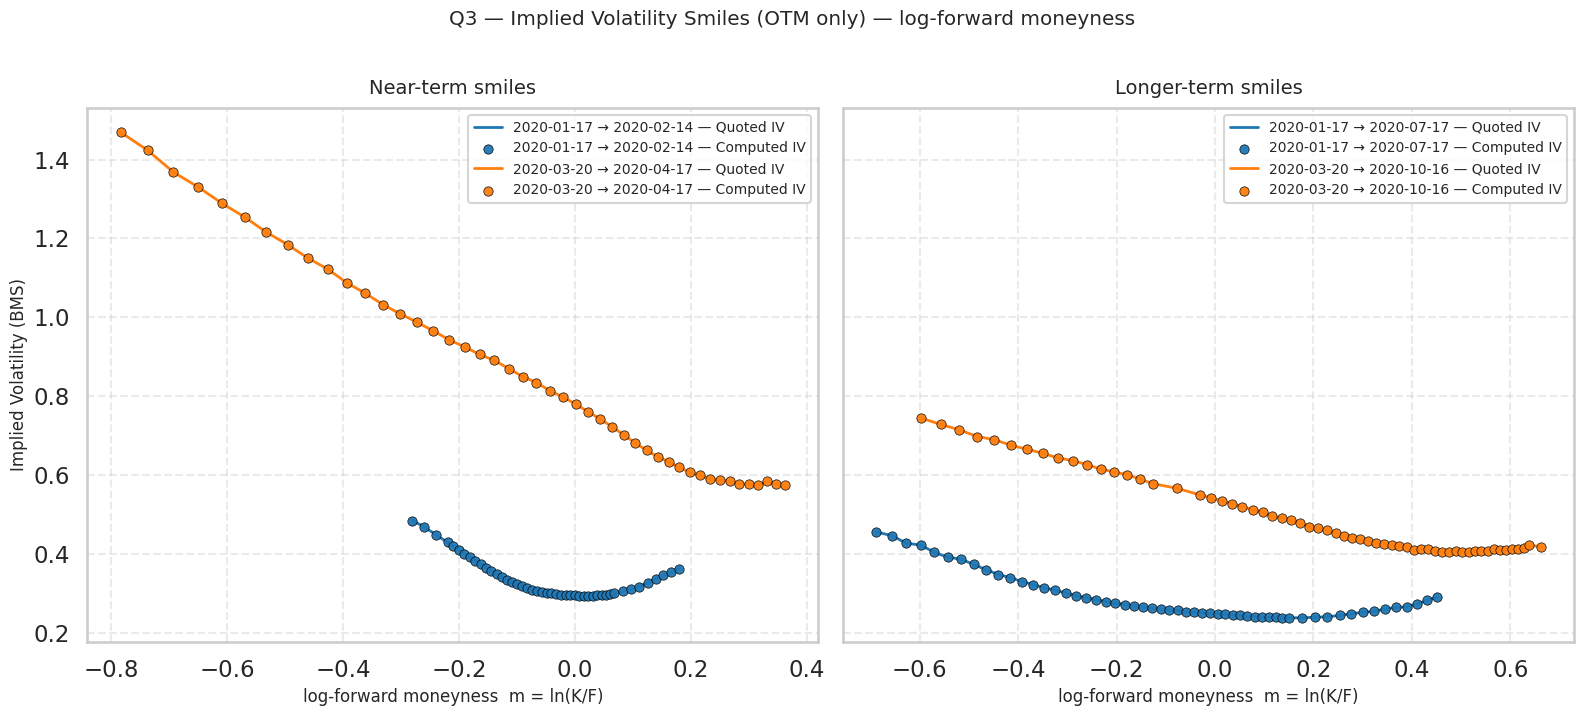

In [ ]:
# ---- Replot Q3 using log-forward moneyness: m = ln(K/F), F = S_ex * exp((r - y) * T) ----
otm_options_log = otm_options.copy()

F = otm_options_log[S_EX] * np.exp((otm_options_log[RF] - otm_options_log['y']) * otm_options_log[T])
otm_options_log["M"] = np.log(otm_options_log[K] / F)   # overwrite M with log-forward moneyness

# --- Patch show so plot_q3_smiles doesn't close the figure
_old_show = plt.show
plt.show = lambda *a, **k: None



# relabel x-axes and update title
plot_q3_smiles(otm_options_log)

fig = plt.gcf()

for ax in fig.axes:
    ax.set_xlabel("log-forward moneyness  m = ln(K/F)")
fig.suptitle("Q3 — Implied Volatility Smiles (OTM only) — log-forward moneyness", y=1.02)

plt.tight_layout()

# restore real show and display
plt.show = _old_show
plt.show()


Using the log forward moneyness measure gets rid of the carry/yield/dividend induced effects/changes, which results in more accurate smiles. These smiles are centered around 0 (with ATM re-anchored at M=0).
Even after this adjustment, the overall conclusions remain unchanged: the level of implied volatility and the skew patterns across quote dates, maturities, and moneyness persist, confirming that the observed differences are structural rather than due to the choice of moneyness measure.

# Question 4

Consider the same OTM options as in the previous question. We now want to scatter
\begin{equation}
    100 \left(\frac{ \text{'impl\_volatility'} }{ \text{'implied\_vol\_bms'} } - 1\right)
\end{equation}
against moneyness (the version you feel most comfortable with). The 'impl_volatility' column provides an implied volatility measure as computed by the data provider using a proprietary algorithm. How should the y-axis be interpreted? Are the magnitudes relatively large or small? Would we obtain the same result comparing CRR and BMS implied volatilities for the in-the-money (ITM) options?

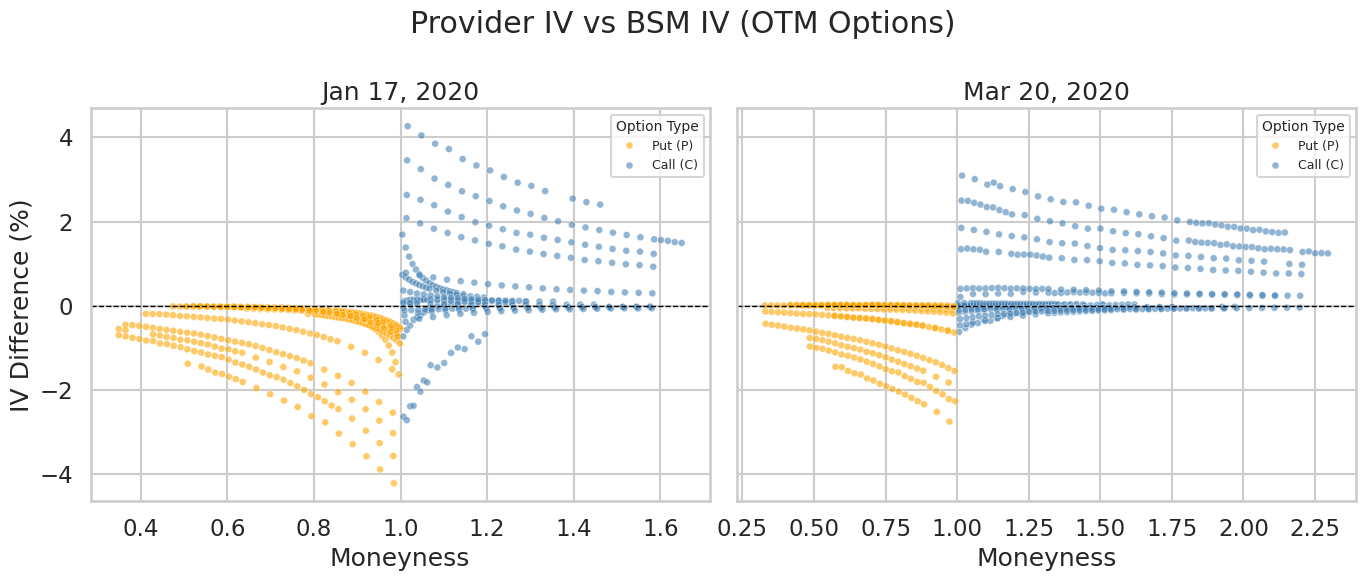

In [ ]:
# set up for dates
def _norm_dates(df):
    df = df.copy()
    for c in ["date", "exdate"]:
        df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()
    return df

opts = _norm_dates(options)
otm  = _norm_dates(otm_options)   # contains iv_bsm

# merge ivs
keys = ["date", "exdate", "cp_flag", "strike"]
df = (
    otm[keys + ["stock_exdiv", "iv_bsm"]]
    .merge(opts[keys + ["impl_volatility"]], on=keys, how="left")
    .dropna(subset=["iv_bsm", "impl_volatility", "stock_exdiv"])
)

# same moneyness
df["moneyness"] = df["strike"] / df["stock_exdiv"]

# OTM filter
df = df[((df["cp_flag"] == "P") & (df["moneyness"] <= 1.0)) |
        ((df["cp_flag"] == "C") & (df["moneyness"] > 1.0))]

# IV difference
df["iv_diff_pct"] = 100 * (df["impl_volatility"] / df["iv_bsm"] - 1)

# select dates
df_jan17 = df[df["date"] == pd.Timestamp("2020-01-17")].copy()
df_mar20 = df[df["date"] == pd.Timestamp("2020-03-20")].copy()

# ---- Plot setup ----
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

palette_cp = {"C": "steelblue", "P": "orange"}
label_map = {"P": "Put (P)", "C": "Call (C)"}

# --- Jan 17, 2020 ---
sns.scatterplot(
    data=df_jan17,
    x="moneyness",
    y="iv_diff_pct",
    hue="cp_flag",
    palette=palette_cp,
    alpha=0.6,
    s=25,
    ax=axes[0]
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Jan 17, 2020")
axes[0].set_xlabel("Moneyness")
axes[0].set_ylabel("IV Difference (%)")

# Legend inside subplot
leg = axes[0].get_legend()
if leg: leg.remove()
handles, labels = axes[0].get_legend_handles_labels()
labels = [label_map.get(l, l) for l in labels]
axes[0].legend(
    handles, labels,
    title="Option Type",
    loc="upper right",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# --- Mar 20, 2020 ---
sns.scatterplot(
    data=df_mar20,
    x="moneyness",
    y="iv_diff_pct",
    hue="cp_flag",
    palette=palette_cp,
    alpha=0.6,
    s=25,
    ax=axes[1]
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Mar 20, 2020")
axes[1].set_xlabel("Moneyness")
axes[1].set_ylabel("")

# Legend inside subplot
leg = axes[1].get_legend()
if leg: leg.remove()
handles, labels = axes[1].get_legend_handles_labels()
labels = [label_map.get(l, l) for l in labels]
axes[1].legend(
    handles, labels,
    title="Option Type",
    loc="upper right",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# ---- Title and layout ----
fig.suptitle("Provider IV vs BSM IV (OTM Options)")
plt.tight_layout()
plt.show()


# Question 5

Convert the present value of dividends corresponding to each option into an approximate convenience yield. Implement the CRR tree with diviended yield ($y$) and obtain your own CRR-implied volatility; use a number of time steps equal to 5 times the days to maturity ('DTM').  Compare it with the 'impl_volatility' provided in the dataframe. In particular, does this yield better approximations than the ones in 'implied_vol_bms'? Support your answer with some summary statistics and a figure.

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq

# --- CRR with dividend yield (stable) ---
def crr_price_stable(S, K, T, r, y, sigma, option_type="C", steps=2000, max_steps=600):
    if T <= 0:
        # immediate expiry -> intrinsic
        return max(0.0, (S-K) if option_type=="C" else (K-S))

    # cap steps to avoid overflow / O(N^2) blowup
    N = int(min(max(1, steps), max_steps))
    dt = T / N
    if sigma <= 0:
        # practically zero vol: discounted forward intrinsic
        f = S*np.exp((r-y)*T)
        return max(0.0, (f - K)*np.exp(-r*T)) if option_type=="C" else max(0.0, (K - f)*np.exp(-r*T))

    u = np.exp(sigma*np.sqrt(dt))
    d = 1.0 / u
    # risk-neutral probability under dividend yield
    p = (np.exp((r - y) * dt) - d) / (u - d)
    # numerically clip p
    p = float(np.clip(p, 1e-12, 1-1e-12))
    disc = np.exp(-r * dt)

    # --- terminal stock prices computed iteratively to avoid overflow ---
    # start at the "all downs" node: S * d^N (compute via logs to avoid under/overflow)
    log_S0 = np.log(S) + N*np.log(d)
    S_k = np.exp(log_S0)

    payoff = np.empty(N+1, dtype=np.float64)
    if option_type == "C":
        for k in range(N+1):
            payoff[k] = max(S_k - K, 0.0)
            S_k *= (u/d)  # move to next node
    else:
        for k in range(N+1):
            payoff[k] = max(K - S_k, 0.0)
            S_k *= (u/d)

    # backward induction
    for _ in range(N):
        payoff = disc * (p*payoff[1:] + (1.0 - p)*payoff[:-1])

    return float(payoff[0])

def implied_vol_crr_stable(S, K, T, r, y, market_price, option_type, steps, max_steps=600):
    # bracketed root: avoid bad bounds with a quick check
    def f(sig):
        return crr_price_stable(S, K, T, r, y, sig, option_type, steps=steps, max_steps=max_steps) - market_price
    try:
        # widen upper bound if necessary
        lo, hi = 1e-6, 3.0
        flo, fhi = f(lo), f(hi)
        if flo * fhi > 0:
            for hi_try in (5.0, 8.0, 12.0):
                if f(lo)*f(hi_try) <= 0:
                    hi = hi_try
                    break
            else:
                return np.nan
        return brentq(f, lo, hi, xtol=1e-8, maxiter=200)
    except Exception:
        return np.nan

# ----- Build CRR-implied vols on your dataframe (robustly) -----
# Steps rule from prompt: N = 5 * DTM, but we'll cap at 600 to stay stable/fast.
def rows_iv_crr(df):
    iv = pd.Series(index=df.index, dtype=float)
    for idx, r in df.iterrows():
        S   = float(r["stock_price"])
        K   = float(r["strike"])
        T   = float(r["YTM"])
        rr  = float(r["risk_free"])
        y   = 0.0 if T <= 0 or r["stock_exdiv"] <= 0 else max(0.0, (1.0/T)*np.log(r["stock_price"]/r["stock_exdiv"]))
        steps = int(max(1, 5 * float(r["DTM"])))
        steps = min(steps, 600)
        cp   = "C" if str(r["cp_flag"]).upper().startswith("C") else "P"
        iv.loc[idx] = implied_vol_crr_stable(S, K, T, rr, y, float(r["option_price"]), cp, steps)
    return iv


In [ ]:
# Compute CRR IVs
options = options.copy()
options["iv_crr"] = rows_iv_crr(options)

# Compare to provider IV safely
valid = options[["strike","stock_exdiv","impl_volatility","iv_crr"]].dropna().copy()
valid["moneyness"] = valid["strike"] / valid["stock_exdiv"]
valid["iv_diff_pct"] = 100 * (valid["impl_volatility"] / valid["iv_crr"] - 1)

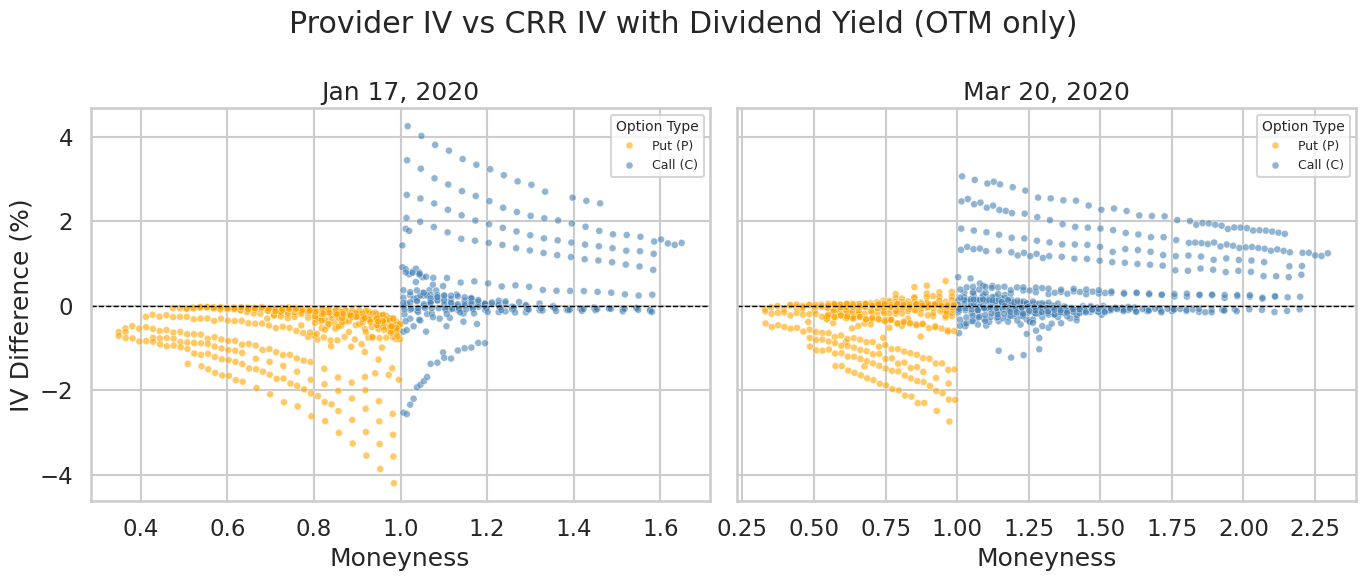

In [ ]:
# Prep: compute moneyness and % diff (clip extremes for readability)
df = options.copy()
df["moneyness"]   = df["strike"] / df["stock_exdiv"]
df["iv_diff_pct"] = 100 * (df["impl_volatility"] / df["iv_crr"] - 1)
df = df.dropna(subset=["moneyness", "iv_diff_pct", "date", "exdate"])

# (Optional) keep only OTM
df = df[((df["cp_flag"]=="P") & (df["moneyness"]<=1.0)) |
        ((df["cp_flag"]=="C") & (df["moneyness"]>1.0))]

# Normalize dates
for c in ["date", "exdate"]:
    df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()

# Split by quote date
df_jan17 = df[df["date"] == pd.Timestamp("2020-01-17")].copy()
df_mar20 = df[df["date"] == pd.Timestamp("2020-03-20")].copy()

# Clip y for readability
df_jan17["iv_diff_pct_clip"] = df_jan17["iv_diff_pct"].clip(-50, 50)
df_mar20["iv_diff_pct_clip"] = df_mar20["iv_diff_pct"].clip(-50, 50)

# ---- Plot: two panels, hue by call/put type ----
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

palette_cp = {"C": "steelblue", "P": "orange"}

# Left panel (Jan 17)
sns.scatterplot(
    data=df_jan17, x="moneyness", y="iv_diff_pct_clip",
    hue="cp_flag", palette=palette_cp, alpha=0.6, s=25, ax=axes[0]
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Jan 17, 2020")
axes[0].set_xlabel("Moneyness")
axes[0].set_ylabel("IV Difference (%)")

# Custom legend (inside quadrant)
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
    handles, ["Put (P)", "Call (C)"],
    title="Option Type",
    loc="upper right",     # try "lower right" or "upper left" if you prefer
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Right panel (Mar 20)
sns.scatterplot(
    data=df_mar20, x="moneyness", y="iv_diff_pct_clip",
    hue="cp_flag", palette=palette_cp, alpha=0.6, s=25, ax=axes[1]
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Mar 20, 2020")
axes[1].set_xlabel("Moneyness")
axes[1].set_ylabel("")

# Custom legend (inside quadrant)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(
    handles, ["Put (P)", "Call (C)"],
    title="Option Type",
    loc="upper right",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# ---- Final layout ----
fig.suptitle("Provider IV vs CRR IV with Dividend Yield (OTM only)")
plt.tight_layout()
plt.show()


# Question 6

Given that the CRR tree should converge to the BMS model, the implied volatility obtained from American options prices using the CRR model can be used in the BMS closed-form formulas to obtain the price at which otherwise identical European options should be traded. Use the approximate convenience yield obtained in the previous question and <span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">the 'impl_volatility' field</span> provided with the data to do so.

Plot the resulting value of early exercise options. (Hint: Because we are using an approximate convenience yield, some of these values could make little economic sense. Use your economic intuition to impose an upper bound on the artifical European prices.) Discuss the observed patterns.

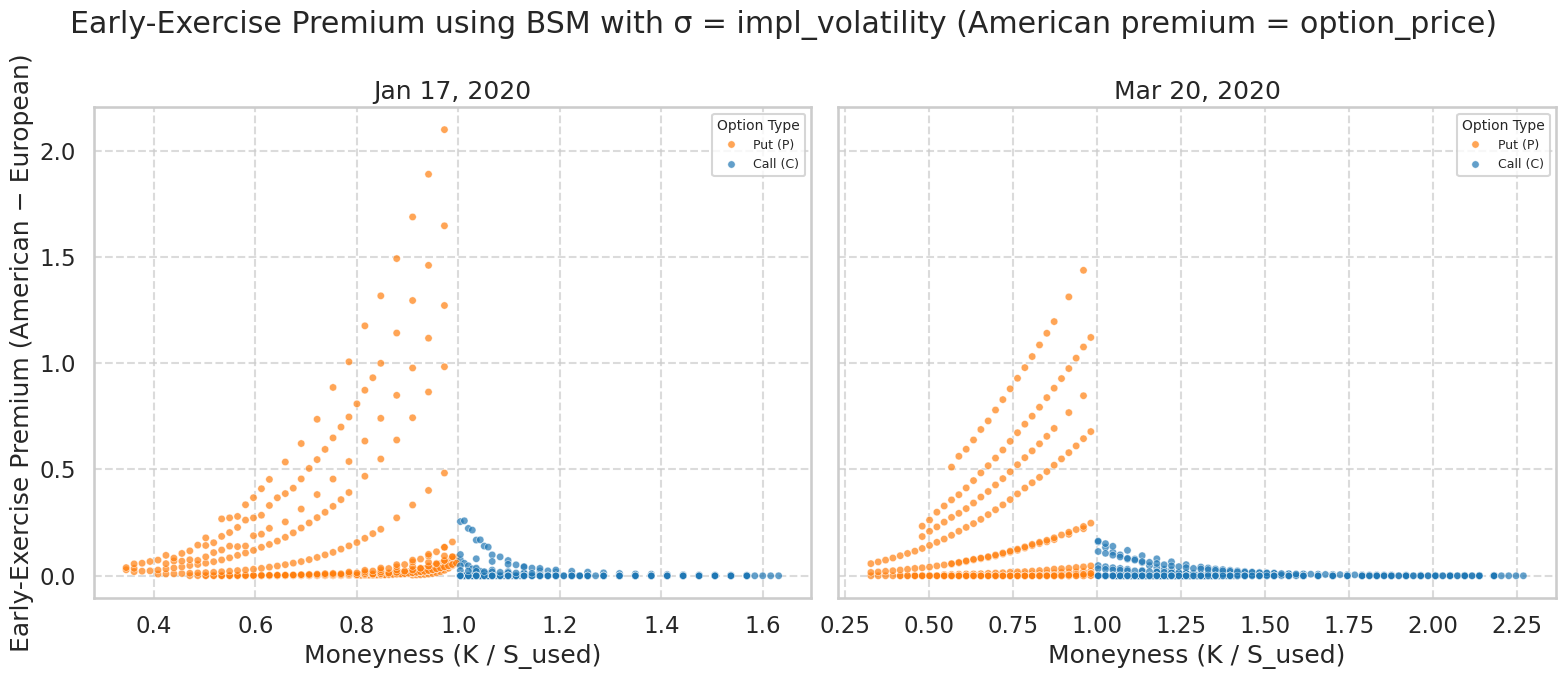

In [ ]:
from scipy.stats import norm

# Black–Scholes with continuous dividend yield

def bsm_price(S, K, T, r, q, sigma, cp_flag):
    if T <= 0:
        return max(0.0, (S - K) if cp_flag == "C" else (K - S))
    if sigma is None or np.isnan(sigma) or sigma <= 0:
        F = S * np.exp((r - q) * T)
        intrinsic_fwd = max(0.0, F - K) if cp_flag == "C" else max(0.0, K - F)
        return np.exp(-r * T) * intrinsic_fwd

    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    if cp_flag == "C":
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

# Convenience yield from
def add_div_yield(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    has_S = "stock_price" in d.columns
    S  = d["stock_price"].astype(float) if has_S else d["stock_exdiv"].astype(float)
    Sx = d["stock_exdiv"].astype(float)
    T  = d["YTM"].astype(float)

    y = np.where(has_S & (T > 0) & (Sx > 0) & (S > 0), np.log(S / Sx) / T, 0.0)
    d["div_yield"] = np.maximum(y, 0.0)

    d["S_used"] = S if has_S else Sx
    d["q_used"] = d["div_yield"] if has_S else 0.0
    return d

# European equivalent  with σ = impl_volatility
def compute_euro_equivalent(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["cp_flag"] = d["cp_flag"].astype(str).str.upper().str[0]

    sig = d["impl_volatility"].astype(float)  #required

    d["euro_equiv"] = [
        bsm_price(S=float(S), K=float(K), T=float(T), r=float(r), q=float(q),
                  sigma=float(s) if pd.notna(s) else np.nan, cp_flag=cp)
        for S, K, T, r, q, s, cp in zip(
            d["S_used"], d["strike"], d["YTM"], d["risk_free"], d["q_used"],
            sig, d["cp_flag"]
        )
    ]


    # Upper bounds

    #European ≤ American option_price
    d["euro_equiv"] = np.minimum(d["euro_equiv"], d["option_price"].astype(float))
    #Soft cap by spot, basically aims to reduce outliers
    d["euro_equiv"] = np.minimum(d["euro_equiv"], d["S_used"].astype(float))
    return d

df = options.copy()

need = [
    "date","exdate","cp_flag","strike",
    "stock_exdiv","YTM","risk_free",
    "impl_volatility","option_price"
]
df = df.dropna(subset=[c for c in need if c in df.columns]).copy()

for c in ["date","exdate"]:
    df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()

# Yield + European equivalent
df = add_div_yield(df)
df = compute_euro_equivalent(df)

# We decided to use option_price as American premium
df["american_premium"] = df["option_price"].astype(float)

# Early-exercise premium
df["early_ex_premium"] = np.maximum(0.0, df["american_premium"] - df["euro_equiv"])

df["moneyness"] = df["strike"] / df["S_used"]

#OTM filter
df = df[
    ((df["cp_flag"]=="C") & (df["moneyness"]>1.0)) |
    ((df["cp_flag"]=="P") & (df["moneyness"]<=1.0))
].copy()

label_map = {
    pd.Timestamp("2020-01-17"): "Jan 17, 2020",
    pd.Timestamp("2020-03-20"): "Mar 20, 2020"
}
df["quote_date"] = df["date"].map(label_map)

#plotting
sns.set_context("talk"); sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

palette_cp = {"C": "tab:blue", "P": "tab:orange"}
label_cp    = {"C": "Call (C)", "P": "Put (P)"}

for ax, qd in zip(axes, ["Jan 17, 2020", "Mar 20, 2020"]):
    sub = df[df["quote_date"] == qd]
    sns.scatterplot(
        data=sub,
        x="moneyness",
        y="early_ex_premium",  #clipping was not needed?!
        hue="cp_flag",
        palette=palette_cp,
        alpha=0.7, s=28, ax=ax
    )
    ax.set_title(qd)
    ax.set_xlabel("Moneyness (K / S_used)")
    ax.set_ylabel("Early-Exercise Premium (American − European)" if qd=="Jan 17, 2020" else "")
    ax.grid(True, linestyle="--", alpha=0.7)

    # Clean legend inside each subplot
    leg = ax.get_legend()
    if leg: leg.remove()
    handles, labels = ax.get_legend_handles_labels()
    labels = [label_cp.get(l, l) for l in labels]
    ax.legend(
        handles, labels, title="Option Type",
        loc="upper right", frameon=True, fontsize=9, title_fontsize=10
    )

fig.suptitle("Early-Exercise Premium using BSM with σ = impl_volatility (American premium = option_price)")
plt.tight_layout()
plt.show()


# Question 7

Muravyev, Pearson and Pollet (2022), suggest that we can use put-call parity to infer borrow fees on stocks. Let $\tilde{h}_t$ be the borrow fee at time $t$. An investor who buy the stock at $S_t$ can lend the stock and receive $\tilde{h}_tS_t$ at time $t+1$.

We can estimate the implied borrow fee from the option prices under Q measure: $\tilde{h}_{t}^{\mathbb{Q}}$. The put-call parity relation including one-day borrow fee is
\begin{equation*}
\hat{S}_t - S_t \left(1 - (1 - e^{-r(T-t)} \tilde{h}_{t}^{\mathbb{Q}})^D \right) = c_t - p_t + e^{-r(T-t)}K
\end{equation*}
where $D$ is the number of days to maturity. Consequently, the one-day borrow fee is:
\begin{equation*}
\tilde{h}_{t}^{\mathbb{Q}} = e^{r(T-t)} \left[1 - \left(1 - \frac{1}{S_t} (\hat{S}_t - c_t + p_t - e^{-r(T-t)} K) \right)^{1/D} \right]
\end{equation*}

Unfortunately, whereas put-call parity applies only to European options, options on individual equities are typically American. However, Muravyev, Pearson and Pollet (2025) suggest that, using a CRR implied volatility for American options, one can use the difference in 1-month ATM implied volatility of puts and calls in to compute an approximation to the
<span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">annualized borrow fee</span>, which is
\begin{equation*}
h_t^{\mathbb{Q}} \approx -(\sigma_c - \sigma_p) / \sqrt{2\pi (T-t)},
\end{equation*}
Compute this approximation on both dates in the sample and discuss your results.

In [ ]:
#wrong

def _norm_dates(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    for c in ["date", "exdate"]:
        d[c] = pd.to_datetime(d[c]).dt.tz_localize(None).dt.normalize()
    return d

def _as_decimal_vol(series: pd.Series) -> pd.Series:
    """Convert % vols to decimals if user data is in percent."""
    s = pd.to_numeric(series, errors="coerce")
    # Heuristic: if median > 1, treat as percent and divide by 100
    if np.nanmedian(s) > 1.0:
        s = s / 100.0
    return s

def compute_borrow_fee_approx(df, target_days=30, iv_col="iv_crr"):
    """
    Computes annualized borrow-fee approx (Muravyev et al.):
        h_t^Q ≈ -(σ_c - σ_p) / sqrt(2π T)
    using ~1M ATM (K/S ≈ 1) implied vols for each quote date.

    Required columns: date, exdate, cp_flag ('C'/'P'), strike, stock_exdiv,
                      YTM (years) or enough to infer it, DTM (days) optional,
                      and iv_col (e.g., 'iv_crr' or 'impl_volatility').
    """
    d = _norm_dates(df)

    # Moneyness
    d["M"] = d["strike"] / d["stock_exdiv"]

    # Ensure vol column exists and is decimal
    if iv_col not in d.columns:
        raise KeyError(f"Column '{iv_col}' not found in DataFrame.")
    d[iv_col] = _as_decimal_vol(d[iv_col])

    # Ensure DTM (days to maturity)
    if "DTM" not in d.columns or d["DTM"].isna().all():
        d["DTM"] = (d["exdate"] - d["date"]).dt.days.astype(float)

    # Ensure YTM (years); if missing, derive from DTM/365
    if "YTM" not in d.columns or d["YTM"].isna().all():
        d["YTM"] = d["DTM"] / 365.0

    # Keep required
    need = ["date", "exdate", "cp_flag", "M", "YTM", "DTM", iv_col]
    d = d.dropna(subset=need).copy()

    out_rows = []
    for qdate in sorted(d["date"].unique()):
        dq = d[d["date"] == qdate]
        if dq.empty:
            continue

        # choose expiry closest to target_days
        # (group by expiry to avoid picking a random row)
        exp_by_dtm = (
            dq[["exdate", "DTM"]]
            .drop_duplicates()
            .assign(dist=lambda x: (x["DTM"] - float(target_days)).abs())
            .sort_values("dist")
        )
        if exp_by_dtm.empty:
            continue
        ex_chosen = exp_by_dtm.iloc[0]["exdate"]
        dqe = dq[dq["exdate"] == ex_chosen]

        # split calls/puts
        cands_c = dqe[dqe["cp_flag"].str.upper().str.startswith("C")].copy()
        cands_p = dqe[dqe["cp_flag"].str.upper().str.startswith("P")].copy()
        if cands_c.empty or cands_p.empty:
            continue

        # pick ATM by nearest moneyness to 1
        pos_c = (cands_c["M"].sub(1.0).abs().values).argmin()
        pos_p = (cands_p["M"].sub(1.0).abs().values).argmin()
        sigma_c = float(cands_c[iv_col].iloc[pos_c])
        sigma_p = float(cands_p[iv_col].iloc[pos_p])

        # time to maturity (years) — average the two ATM contracts
        T_c = float(cands_c["YTM"].iloc[pos_c])
        T_p = float(cands_p["YTM"].iloc[pos_p])
        T = np.nanmean([T_c, T_p])
        if not np.isfinite(T):  # fallback
            T = float(dqe["YTM"].median())
        T = max(T, 1e-12)

        # Muravyev et al. approximation
        h_approx = -(sigma_c - sigma_p) / np.sqrt(2.0 * np.pi * T)

        out_rows.append({
            "quote_date": pd.Timestamp(qdate).date(),
            "expiry": pd.Timestamp(ex_chosen).date(),
            "sigma_c": sigma_c,
            "sigma_p": sigma_p,
            "T_years": T,
            "h_approx": h_approx
        })

    return pd.DataFrame(out_rows)

def plot_borrow_fee(bf_df: pd.DataFrame):
    """Bar plot of borrow-fee approximation by quote date and expiry."""
    if bf_df.empty:
        print("No results to plot.")
        return
    plt.figure(figsize=(8, 5))
    sns.barplot(data=bf_df, x="quote_date", y="h_approx", hue="expiry", palette="tab10")
    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.ylabel(r"Borrow Fee Approx. $h_t^Q$")
    plt.xlabel("Quote Date")
    plt.title("Borrow Fee Approximation by Quote Date and Expiry (~1M ATM)")
    plt.legend(title="Expiry")
    plt.tight_layout()
    plt.show()

# --- Example usage ---
# Choose which volatility per the assignment; use 'impl_volatility' if that's required
bf = compute_borrow_fee_approx(options, target_days=30, iv_col="impl_volatility")
print(bf)
# plot_borrow_fee(bf)


   quote_date      expiry   sigma_c   sigma_p   T_years  h_approx
0  2020-01-17  2020-02-14  0.293014  0.292800  0.076712 -0.000308
1  2020-03-20  2020-04-17  0.788194  0.772654  0.076712 -0.022384


In [ ]:
#wrong

def compute_borrow_fee_approx(
    df,
    target_days=30,
    iv_col="iv_crr",
    r_col="rf",
    spot_col="stock_exdiv",
    q_col=None
):
    """
    Computes annualized borrow-fee approx (Muravyev et al.):
        h_t^Q ≈ -(σ_c - σ_p) / sqrt(2π T)

    Uses forward-ATM and OTM-implied vols (Muravyev, Pearson & Pollet 2025).
    """
    d = _norm_dates(df).copy()
    d[iv_col] = _as_decimal_vol(d[iv_col])

    if "DTM" not in d.columns or d["DTM"].isna().all():
        d["DTM"] = (d["exdate"] - d["date"]).dt.days.astype(float)
    if "YTM" not in d.columns or d["YTM"].isna().all():
        d["YTM"] = d["DTM"] / 365.0

    need = ["date", "exdate", "cp_flag", "strike", "YTM", "DTM", iv_col]
    d = d.dropna(subset=need).copy()

    out_rows = []

    for qdate in sorted(d["date"].unique()):
        dq = d[d["date"] == qdate]
        if dq.empty:
            continue

        # expiry closest to target_days
        exp_by_dtm = (
            dq[["exdate", "DTM"]]
            .drop_duplicates()
            .assign(dist=lambda x: (x["DTM"] - float(target_days)).abs())
            .sort_values("dist")
        )
        if exp_by_dtm.empty:
            continue
        ex_chosen = exp_by_dtm.iloc[0]["exdate"]
        dqe = dq[dq["exdate"] == ex_chosen].copy()

        # --- Forward level ---
        T_slice = float(np.nanmedian(dqe["YTM"]))
        T_slice = max(T_slice, 1e-12)
        r = float(np.nanmedian(dqe.get(r_col, 0.0)))

        has_exdiv = (spot_col in dqe.columns) and dqe[spot_col].notna().any()
        has_q_and_spot = (
            (q_col is not None)
            and (q_col in dqe.columns)
            and ("spot" in dqe.columns)
            and dqe["spot"].notna().any()
        )

        if has_exdiv:
            S_ref = float(np.nanmedian(dqe[spot_col]))
            K_star = S_ref * np.exp(r * T_slice)
        elif has_q_and_spot:
            q = float(np.nanmedian(dqe[q_col]))
            S_ref = float(np.nanmedian(dqe["spot"]))
            K_star = S_ref * np.exp((r - q) * T_slice)
        else:
            S_ref = float(np.nanmedian(dqe.get("spot", dqe.get(spot_col, np.nan))))
            K_star = S_ref if np.isfinite(S_ref) else float(np.nanmedian(dqe["strike"]))

        # --- OTM-by-forward selection + interpolation to K* ---
        calls = dqe[dqe["cp_flag"].str.upper().str.startswith("C")].copy()
        puts  = dqe[dqe["cp_flag"].str.upper().str.startswith("P")].copy()
        if calls.empty or puts.empty:
            continue

        def iv_at_Kstar(side_df, is_call, K_star, iv_col):
            sdf = side_df.dropna(subset=["strike", iv_col, "YTM"]).copy()
            # OTM filter
            if is_call:
                sdf = sdf[sdf["strike"] >= K_star]
            else:
                sdf = sdf[sdf["strike"] <= K_star]
            if sdf.empty:
                return np.nan, np.nan

            sdf = sdf.sort_values("strike")
            Ks = sdf["strike"].values
            sig = sdf[iv_col].values
            Ts = sdf["YTM"].values

            if len(Ks) == 1:
                return float(sig[0]), float(Ts[0])

            # nearest two strikes around K*
            if is_call:
                idx = np.searchsorted(Ks, K_star, side="left")
                i0 = max(0, idx - 1)
                i1 = min(len(Ks) - 1, idx)
            else:
                idx = np.searchsorted(Ks, K_star, side="right") - 1
                i1 = min(len(Ks) - 1, max(0, idx))
                i0 = max(0, i1 - 1)

            K0, K1 = float(Ks[i0]), float(Ks[i1])
            s0, s1 = float(sig[i0]), float(sig[i1])
            T0, T1 = float(Ts[i0]), float(Ts[i1])
            if K0 == K1:
                return s0, np.nanmean([T0, T1])
            w = (K_star - K0) / (K1 - K0)
            sigma = s0 + w * (s1 - s0)
            Tside = T0 + w * (T1 - T0)
            return float(sigma), float(Tside)

        sigma_c, T_c = iv_at_Kstar(calls, True, K_star, iv_col)
        sigma_p, T_p = iv_at_Kstar(puts, False, K_star, iv_col)

        T = float(np.nanmean([T_slice, T_c, T_p]))
        T = max(T, 1e-12)

        h_approx = -(sigma_c - sigma_p) / np.sqrt(2.0 * np.pi * T)

        out_rows.append({
            "quote_date": pd.Timestamp(qdate).date(),
            "expiry": pd.Timestamp(ex_chosen).date(),
            "K_star": K_star,
            "sigma_c": sigma_c,
            "sigma_p": sigma_p,
            "T_years": T,
            "h_approx": h_approx,
        })

    return pd.DataFrame(out_rows).sort_values(["quote_date", "expiry"]).reset_index(drop=True)

bf = compute_borrow_fee_approx(options, target_days=30, iv_col="impl_volatility", r_col="rf")
print(bf)


   quote_date      expiry      K_star   sigma_c   sigma_p   T_years  h_approx
0  2020-01-17  2020-02-14  317.960945  0.292353  0.292730  0.076712  0.000544
1  2020-03-20  2020-04-17  229.240000  0.788194  0.777575  0.076712 -0.015296


In [ ]:


#  borrow fee approx
def compute_borrow_fee_approx(
    df: pd.DataFrame,
    target_days: int = 30,
    iv_col: str = "impl_volatility",  #contains the CRR implied vol
    r_col: str = "risk_free",
    spot_col: str = "stock_exdiv"
) -> pd.DataFrame:

    d = df.copy()

    #  Compute maturity
    for c in ["date", "exdate"]:
        d[c] = pd.to_datetime(d[c]).dt.tz_localize(None).dt.normalize()

    if "DTM" not in d.columns:
        d["DTM"] = (d["exdate"] - d["date"]).dt.days.astype(float)
    if "YTM" not in d.columns:
        d["YTM"] = d["DTM"] / 365.0

    d = d.dropna(subset=["cp_flag", "strike", "YTM", iv_col])
    d["cp_flag"] = d["cp_flag"].astype(str).str.upper().str[0]
    d[iv_col] = d[iv_col].astype(float)

    out = []

    # Iterate by quote date
    for qdate in sorted(d["date"].unique()):
        dq = d[d["date"] == qdate]
        if dq.empty:
            continue

        # ATM options
        exp_choice = (
            dq[["exdate", "DTM"]]
            .drop_duplicates()
            .assign(diff=lambda x: (x["DTM"] - target_days).abs())
            .sort_values("diff")
        )
        if exp_choice.empty:
            continue
        ex_chosen = exp_choice.iloc[0]["exdate"]
        dqe = dq[dq["exdate"] == ex_chosen].copy()

        if dqe.empty:
            continue

        # T and r selection
        T = float(np.nanmedian(dqe["YTM"]))
        r = float(np.nanmedian(dqe[r_col])) if r_col in dqe.columns else 0.0
        T = max(T, 1e-12)

        # Spot and forward level selection
        if spot_col in dqe.columns:
            S_ref = float(np.nanmedian(dqe[spot_col]))
        elif "stock_price" in dqe.columns:
            S_ref = float(np.nanmedian(dqe["stock_price"]))
        else:
            S_ref = float(np.nanmedian(dqe["strike"]))
        K_star = S_ref * np.exp(r * T)

        #  Split calls & puts
        calls = dqe[dqe["cp_flag"] == "C"].copy()
        puts  = dqe[dqe["cp_flag"] == "P"].copy()
        if calls.empty or puts.empty:
            continue

        #  Interpolate σ at K*
        def iv_interp(df_side, is_call):
            sdf = df_side.dropna(subset=["strike", iv_col])
            sdf = sdf.sort_values("strike")

            # options filters for otm options
            sdf = sdf[sdf["strike"] >= K_star] if is_call else sdf[sdf["strike"] <= K_star]
            if sdf.empty:
                return np.nan

            Ks = sdf["strike"].values
            sig = sdf[iv_col].values

            if len(Ks) == 1:
                return float(sig[0])

            idx = np.searchsorted(Ks, K_star) #allows to find closest strikes
            i0 = max(0, idx - 1)
            i1 = min(len(Ks) - 1, idx)
            if i0 == i1:
                return float(sig[i0])

            K0, K1 = Ks[i0], Ks[i1]
            s0, s1 = sig[i0], sig[i1]
            w = (K_star - K0) / (K1 - K0)
            return float(s0 + w * (s1 - s0))

        sigma_c = iv_interp(calls, True)
        sigma_p = iv_interp(puts, False)

        if np.isnan(sigma_c) or np.isnan(sigma_p):
            continue

        #Approximation of H
        h_approx = -(sigma_c - sigma_p) / np.sqrt(2.0 * np.pi * T)

        out.append({
            "quote_date": pd.Timestamp(qdate).date(),
            "expiry": pd.Timestamp(ex_chosen).date(),
            "K_star": K_star,
            "sigma_c": sigma_c,
            "sigma_p": sigma_p,
            "T_years": T,
            "h_approx": h_approx
        })

    out_df = pd.DataFrame(out).sort_values(["quote_date", "expiry"]).reset_index(drop=True)
    return out_df

#run on data set
bf = compute_borrow_fee_approx(
    options,
    target_days=30,
    iv_col="impl_volatility",   # same field as Q6
    r_col="risk_free",
    spot_col="stock_exdiv"
)

print(bf)


   quote_date      expiry      K_star   sigma_c   sigma_p   T_years  h_approx
0  2020-01-17  2020-02-14  318.367026  0.292353  0.292800  0.076712  0.000644
1  2020-03-20  2020-04-17  229.390221  0.788194  0.791236  0.076712  0.004382
